In [12]:
#Importing Libraries

#Importing dependencies (pandas, json, requests, numpy, matplotlib)
import pandas as pd
import json
import requests
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

**Work from CSV data**

The CSV files that are pulled in here (features_df.csv, track_df.csv) are both created using the Spotipy API. For more information on creating these files with API calls, please view the pull_spotify_data.ipynb Jupyter Notebook in this repository.

In [13]:
# Import CSVs
# Tracks
csv_path = "track_df.csv"
track_df = pd.read_csv(csv_path)
track_df.head()

# Audio features
csv_path = "features_df.csv"
audio_features_df = pd.read_csv(csv_path)
audio_features_df.head()

,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0,0.847,0.6220,1,-6.747,0,0.0903,0.119,0.000000,0.285,0.220,130.001,audio_features,4rXLjWdF2ZZpXCVTfWcshS,spotify:track:4rXLjWdF2ZZpXCVTfWcshS,https://api.spotify.com/v1/tracks/4rXLjWdF2ZZp...,https://api.spotify.com/v1/audio-analysis/4rXL...,125040,4
1,1,0.511,0.5320,5,-5.745,1,0.0560,0.169,0.000000,0.311,0.322,137.827,audio_features,3k79jB4aGmMDUQzEwa46Rz,spotify:track:3k79jB4aGmMDUQzEwa46Rz,https://api.spotify.com/v1/tracks/3k79jB4aGmMD...,https://api.spotify.com/v1/audio-analysis/3k79...,219724,4
2,2,0.557,0.7740,7,-5.275,0,0.3510,0.012,0.000000,0.396,0.397,111.975,audio_features,67nepsnrcZkowTxMWigSbb,spotify:track:67nepsnrcZkowTxMWigSbb,https://api.spotify.com/v1/tracks/67nepsnrcZko...,https://api.spotify.com/v1/audio-analysis/67ne...,246134,4
3,3,0.712,0.6030,8,-5.520,1,0.0262,0.186,0.000000,0.115,0.670,97.994,audio_features,1Lo0QY9cvc8sUB2vnIOxDT,spotify:track:1Lo0QY9cvc8sUB2vnIOxDT,https://api.spotify.com/v1/tracks/1Lo0QY9cvc8s...,https://api.spotify.com/v1/audio-analysis/1Lo0...,265493,4
4,4,0.444,0.0911,0,-17.665,1,0.0307,0.959,0.000001,0.098,0.142,78.403,audio_features,6wf7Yu7cxBSPrRlWeSeK0Q,spotify:track:6wf7Yu7cxBSPrRlWeSeK0Q,https://api.spotify.com/v1/tracks/6wf7Yu7cxBSP...,https://api.spotify.com/v1/audio-analysis/6wf7...,222370,4


In [14]:
#Merge the two dataframes together
merged_df = pd.merge(track_df, audio_features_df, left_on="track_id", right_on="id", how="inner")

#remove original index columns, as well as columns containing information that isn't useful for our analysis/visualizations
merged_df = merged_df.drop(columns=["Unnamed: 0_x", "Unnamed: 0_y", "type", "mode", "uri", "track_href", "analysis_url", "id"])
merged_df 

,artist_name,track_name,track_id,popularity,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Gunna,fukumean,4rXLjWdF2ZZpXCVTfWcshS,96,0.847,0.6220,1,-6.747,0.0903,0.1190,0.000000,0.285,0.220,130.001,125040,4
1,Olivia Rodrigo,vampire,3k79jB4aGmMDUQzEwa46Rz,98,0.511,0.5320,5,-5.745,0.0560,0.1690,0.000000,0.311,0.322,137.827,219724,4
2,Travis Scott,MELTDOWN (feat. Drake),67nepsnrcZkowTxMWigSbb,94,0.557,0.7740,7,-5.275,0.3510,0.0120,0.000000,0.396,0.397,111.975,246134,4
3,Luke Combs,Fast Car,1Lo0QY9cvc8sUB2vnIOxDT,91,0.712,0.6030,8,-5.520,0.0262,0.1860,0.000000,0.115,0.670,97.994,265493,4
4,Billie Eilish,What Was I Made For? [From The Motion Picture ...,6wf7Yu7cxBSPrRlWeSeK0Q,98,0.444,0.0911,0,-17.665,0.0307,0.9590,0.000001,0.098,0.142,78.403,222370,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,JUNNY,INVITATION (Feat. Gaeko),3ISOK4T54v6O1g1AB8FiEK,75,0.799,0.8490,4,-3.040,0.0704,0.0726,0.000000,0.116,0.913,124.032,191360,4
996,Luke Combs,Growin' Up and Gettin' Old,24Z0qiHUR9cTB4UfGUqCnj,71,0.511,0.6000,2,-5.699,0.0268,0.1600,0.000005,0.114,0.269,146.051,233667,4
997,Russ,NASTY - Extended Version,08XHGvYxioT9gMP6TPuaLR,70,0.819,0.3550,5,-7.907,0.1550,0.0274,0.000008,0.109,0.242,83.526,176766,4
998,Nessa Barrett,lie,2GQqCyDCD0Z7BL2otJkFRh,72,0.648,0.5010,2,-8.262,0.0399,0.3190,0.000081,0.127,0.656,155.040,214044,4


In [15]:
# Create a function that allows us to create a scatter plot with any two of the columns in the data frame
# It also creates a linear regression line and calculates the r value
# The function takes in the x and y values as well as making the title of the graph equal to the column names with "vs." in between

def music_plot(x_values, y_values):
    # Generate scatter plot using matplotlib (plt.scatter)
    plt.scatter(x_values, y_values, marker="o", facecolors="skyblue", edgecolors="black")

    # Generate the titles and labels for the graph, capitalize the first letter of each word
    plt.title(f"{x_values.name.capitalize()} vs. {y_values.name.capitalize()}")
    plt.xlabel(x_values.name.capitalize())
    plt.ylabel(y_values.name.capitalize())

    # Add a grid to the graph
    plt.grid()

    # Calculate the linear regression line
    x_values = x_values.astype('float')
    y_values = y_values.astype('float')
    (slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))
    print(f"The r-value is: {rvalue}")

    # Plot and annotate the linear regression line
    plt.plot(x_values,regress_values,"r-")
    plt.annotate(line_eq,(min(x_values),min(y_values)),fontsize=15,color="red")

    # Show the figure
    plt.show()

The r-value is: -0.05471244081718012


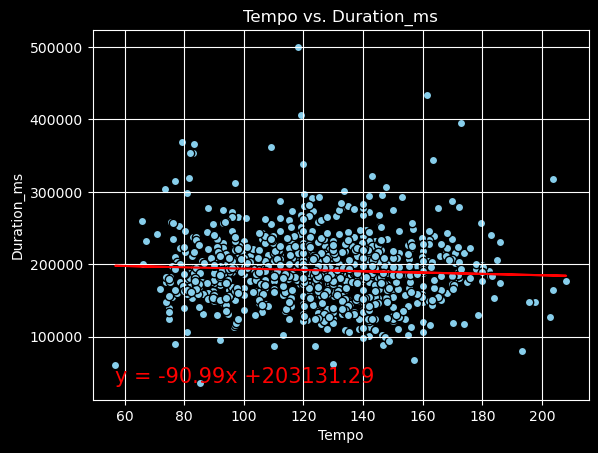

In [16]:
# Test the function music_plot()
music_plot(merged_df['tempo'], merged_df['duration_ms'])

The r-value is: 0.13853422105156152


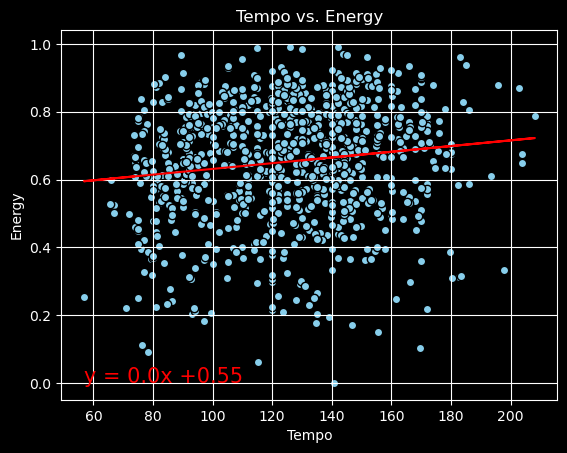

In [17]:
# Test the function music_plot()
music_plot(merged_df['tempo'], merged_df['energy'])

In [78]:
# Create a new dataframe called artist_counts_df that has the following columns:
# artist_name, track_count, track_names, track_ids
# artist_name: the name of the artist
# track_count: the number of tracks by the artist in merged_df
# track_names: a list of the names of the tracks by the artist in merged_df
# track_ids: a list of the ids of the tracks by the artist in merged_df
# artist_counts_df should be sorted by track_count in descending order
# artist_counts_df should only contain artists with 2 or more tracks in merged_df

# Filter out artists with less than 2 tracks
merged_df_filtered = merged_df.groupby('artist_name').filter(lambda x: len(x) >= 2)

# Create the artist_counts_df dataframe
artist_counts_df = merged_df_filtered.groupby('artist_name').agg({
    'track_name': lambda x: list(x),  # Change 'track_id' to 'track_name'
    'track_id': lambda x: list(x)  # Change 'track_id' to 'track_ids'
})

artist_counts_df.head()

# Rename the columns
artist_counts_df = artist_counts_df.rename(columns={
    'track_name': 'track_names', 
    'track_id': 'track_ids'  # Change 'id_<lambda>' to 'track_id_<lambda>'
})

for index, artist in artist_counts_df.iterrows():
    artist_counts_df.loc[index, 'track_count'] = int(len(artist['track_names']))

# Change column order in artist_counts_df
artist_counts_df = artist_counts_df[['track_count', 'track_names', 'track_ids']]

# Sort artist_counts_df by track_count in descending order
artist_counts_df = artist_counts_df.sort_values(by='track_count', ascending=False)

# Display sample data from artist_counts_df
artist_counts_df.head()


,track_count,track_names,track_ids
artist_name,,,
KAROL G,65.0,"[TQG, AMARGURA, S91, WATATI (feat. Aldo Ranks)...","[0DWdj2oZMBFSzRsi2Cvfzf, 505v13epFXodT9fVAJ6h8..."
Post Malone,63.0,"[Chemical, Enough Is Enough, Overdrive, Someth...","[5w40ZYhbBMAlHYNDaVJIUu, 3BHFResGQiUvbYToUdaDQ..."
Feid,43.0,"[Classy 101, Niña Bonita, VENTE CONMIGO, Class...","[6XSqqQIy7Lm7SnwxS4NrGx, 3Gs7mVfWKl567mjozgxmX..."
Morgan Wallen,37.0,"[Last Night, Last Night, Thinkin’ Bout Me, You...","[59uQI0PADDKeE6UZDTJEe8, 7K3BhSpAxZBznislvUMVt..."
Metro Boomin,31.0,[Calling (Spider-Man: Across the Spider-Verse)...,"[5rurggqwwudn9clMdcchxT, 39MK3d3fonIP8Mz9oHCTB..."


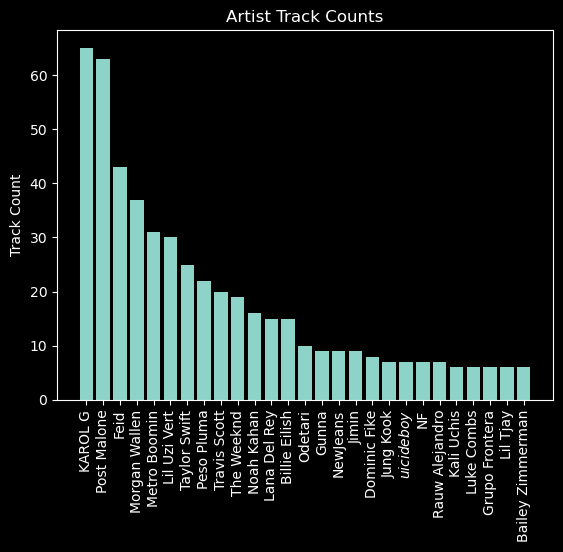

In [79]:
# Create a bar chart of the data in the artist_counts_df dataframe, plotting all artists where artist_counts_df['track_count'] is greater than 5.
# Create the bar chart using the matplotlib.pyplot.bar() function.
# Use the artist_counts_df['artist_name'] column for the x-axis labels.
# Use the artist_counts_df['track_count'] column for the y-axis values.
# Use the artist_counts_df['artist_name'] column for the tick labels.
# Use the plt.xticks() function to rotate the tick labels 90 degrees.
# Use the plt.ylabel() function to add the y-axis label.
# Use the plt.title() function to add the chart title.
# Use the plt.show() function to display the chart.

filtered_df = artist_counts_df[artist_counts_df['track_count'] > 5]

# Create the bar chart using the filtered dataframe
plt.bar(filtered_df.index, filtered_df['track_count'])

# Set the x-axis tick labels to the artist names and rotate them 90 degrees
plt.xticks(filtered_df.index, rotation=90)

# Add the y-axis label
plt.ylabel('Track Count')

# Add the chart title
plt.title('Artist Track Counts')

# Display the chart
plt.show()


In [20]:
# Create a summary statistics dataframe that includes the summary statistics for all the numerical columns in the merged_df dataframe
summary_df = merged_df.describe()

# Use the Pandas transpose function to flip the axis
summary_df = summary_df.transpose()

# Use the Pandas to_csv function to save the summary statistics dataframe to a csv file
summary_df.to_csv('summary_statistics.csv')

# Check dataframe info
summary_df.head()

,count,mean,std,min,25%,50%,75%,max
popularity,1000.0,67.428000,27.019342,0.000000,70.00000,76.0000,82.00000,100.000
danceability,1000.0,0.658810,0.150145,0.143000,0.55200,0.6725,0.77700,0.971
energy,1000.0,0.651236,0.171638,0.000116,0.55100,0.6690,0.78225,0.991
key,1000.0,5.145000,3.603743,0.000000,2.00000,5.0000,8.00000,11.000
loudness,1000.0,-6.210125,2.685936,-37.894000,-7.47425,-5.6885,-4.48875,1.002


In [21]:
# For each artist in the artist_counts_df, get the track_IDs for artists where artist_counts_df['track_count'] > 1
# Start by filtering the artist_counts_df to only include artists with more than one track
multi_track_artist_counts_df = artist_counts_df[artist_counts_df['track_count'] > 1]

multi_track_artist_track_IDs = []

# Create a list of track_IDs for each artist in multi_track_artist_counts_df['tracks']
for i in multi_track_artist_counts_df['tracks']:
    # Add the list from each row to the multi track list so that we end up with a list of strings without other lists
    multi_track_artist_track_IDs = multi_track_artist_track_IDs + i

print(multi_track_artist_track_IDs)
multi_track_artist_counts_df.head()

# Plot this set of tracks vs. the set of all tracks vs. the set of tracks by artists with only 1 track in the dataset

['0DWdj2oZMBFSzRsi2Cvfzf', '505v13epFXodT9fVAJ6h8k', '7EpOXgSRgnglRWr86pZfGU', '6MZi5j60L80SZLBxN0bv8s', '3HqcNJdZ2seoGxhn0wVNDK', '6otePxalBK8AVa20xhZYVQ', '4NoOME4Dhf4xgxbHDT7VGe', '16dUQ4quIHDe4ZZ0wF1EMN', '4bycD60yZgR6anIBtmU8UH', '3CNbrXrUrEARw8zeKNCdYo', '7mLPSkAJraASgNk6ywyTkp', '1dw7qShk971xMD6r6mA4VN', '6Vn1vje8yMw2OY6IOk9dkH', '3XB5uhhlYSnkxpSihkNQwh', '3gOI5aQD4mOMLsP3aWrkon', '5yAIrkplUEpMNeojW8Q30o', '6ejks4eS7DOoYW8hrpRcDV', '1d9DieOOLD8yaoEmUQhE8t', '5yw9b6D8TZr7aPloY9p9ha', '3AM3WIveCRPUnH2Cizyz1y', '3s5VBxbUdXkOcl4ahh0PIo', '04VUBZ72aOG3tdzjTCGcHr', '2PiyjyC6bcTMzWPSjtvxT8', '45yj0IqpW5J6KxkX6A4uv1', '51SKHLw2MpNUMMwod3f74b', '1viv9gZMZM3LVpES0pxvHg', '1SD8sZ5OCIfmzHqs8VwFFr', '5EiCq6wP0lTTvWH8mkjnqY', '43acCXjRROWYAMlQhf3xfR', '3J0mWaiGubQoQBlcw3cUe2', '2RoFLv11zJfy5GqFnFEYcT', '3GCFCVLVo6FFZ5WO4vdXTv', '0Vj6KMcTjU33qtz93iYD7u', '4WqSUrVzy7NBf5psaDedin', '0ycz51Qwd9zBeNWtesUcdP', '1TLUH5TVNVE07dNeTGbmgi', '7c73muZWuHTRPMgujwypyx', '3GVSoqoteGu3yDkffFaGbM', '0bzlYYW4rU

,artist_name,track_count,tracks
146,Kylie Minogue,65,"[0DWdj2oZMBFSzRsi2Cvfzf, 505v13epFXodT9fVAJ6h8..."
250,EI8HT,63,"[5w40ZYhbBMAlHYNDaVJIUu, 3BHFResGQiUvbYToUdaDQ..."
103,ENHYPEN,43,"[6XSqqQIy7Lm7SnwxS4NrGx, 3Gs7mVfWKl567mjozgxmX..."
212,SEVENTEEN,37,"[59uQI0PADDKeE6UZDTJEe8, 7K3BhSpAxZBznislvUMVt..."
206,Chencho Corleone,31,"[5rurggqwwudn9clMdcchxT, 39MK3d3fonIP8Mz9oHCTB..."


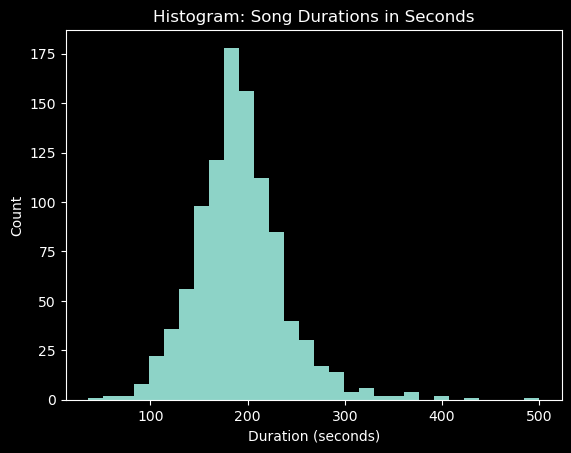

In [95]:
# Create a histogram of song durations, pulling the tracks from the merged_df dataframe and using the duration_ms column

# Convert duration_ms to seconds
merged_df['duration_sec'] = merged_df['duration_ms'] / 1000

# Create a histogram of song durations
plt.hist(merged_df['duration_sec'], bins=30)

# Add labels and title
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.title('Histogram: Song Durations in Seconds')

# Show the plot
plt.show()


Total outliers: 32
Outliers below IQR: 5
Outliers above IQR: 27


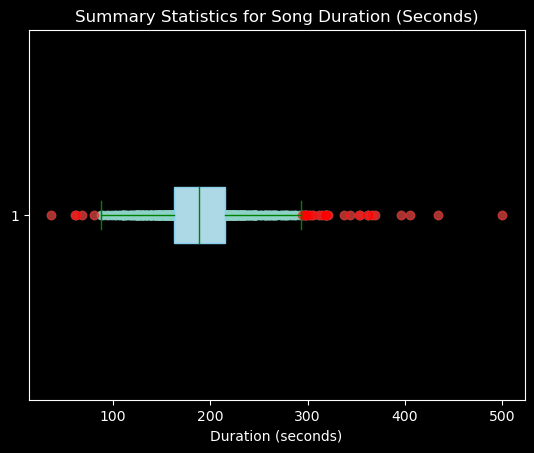

count    1000.000000
mean      191.876534
std        46.962457
min        36.227000
25%       163.012750
50%       188.514500
75%       215.199000
max       500.117000
Name: duration_sec, dtype: float64


In [99]:
# Calculate summary statistics for the duration_sec column
duration_sec_summary = merged_df['duration_sec'].describe()

# Create a box plot with the information in duration_sec_summary
# Use the matplotlib.plt library to create the plot
fig, ax = plt.subplots()
ax.boxplot(merged_df['duration_sec'], vert=False, showfliers=False, patch_artist=True, boxprops=dict(facecolor='lightblue', color='skyblue'), whiskerprops=dict(color='g'), capprops=dict(color='g'), medianprops=dict(color='g'))

# Add axis labels and a title
ax.set_xlabel('Duration (seconds)')
ax.set_title('Summary Statistics for Song Duration (Seconds)')

# Plot each individual value in merged_df['duration_sec'] and highlight the outliers
outliers_below = merged_df['duration_sec'][merged_df['duration_sec'] < duration_sec_summary['25%'] - 1.5 * (duration_sec_summary['75%'] - duration_sec_summary['25%'])]
outliers_above = merged_df['duration_sec'][merged_df['duration_sec'] > duration_sec_summary['75%'] + 1.5 * (duration_sec_summary['75%'] - duration_sec_summary['25%'])]
plt.scatter(merged_df['duration_sec'], [1] * len(merged_df['duration_sec']), alpha=0.5)
plt.scatter(outliers_below, [1] * len(outliers_below), color='r', alpha=0.5)
plt.scatter(outliers_above, [1] * len(outliers_above), color='r', alpha=0.5)

# Now, calculate and print the amount of outliers, total and below/above the IQR
print('Total outliers: ' + str(len(outliers_below) + len(outliers_above)))
print('Outliers below IQR: ' + str(len(outliers_below)))
print('Outliers above IQR: ' + str(len(outliers_above)))

# Create two dataframes of the outliers that includes: song name, artist name, duration_sec
# One of the dataframes for the outliers below the IQR and one for the outliers above the IQR
outliers_above_df = merged_df[merged_df['duration_sec'] > duration_sec_summary['75%'] + 1.5 * (duration_sec_summary['75%'] - duration_sec_summary['25%'])]
outliers_below_df = merged_df[merged_df['duration_sec'] < duration_sec_summary['25%'] - 1.5 * (duration_sec_summary['75%'] - duration_sec_summary['25%'])]

# Show the plot
plt.show()

# Print the summary statistics
print(duration_sec_summary)
